In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43


In [41]:
drop_cols = ['name_of_drug', 'use_case_for_drug', 'drug_approved_by_UIC', 'number_of_times_prescribed']
train = df_train.drop(drop_cols, axis=1)
train.head()

,patient_id,review_by_patient,effectiveness_rating
0,206461,"""It has no side effect, I take it in combinati...",9
1,95260,"""My son is halfway through his fourth week of ...",8
2,92703,"""I used to take another oral contraceptive, wh...",5
3,35696,"""Suboxone has completely turned my life around...",9
4,155963,"""2nd day on 5mg started to work with rock hard...",2


In [42]:
train.drop('patient_id', axis=1, inplace=True)
train.head()

,review_by_patient,effectiveness_rating
0,"""It has no side effect, I take it in combinati...",9
1,"""My son is halfway through his fourth week of ...",8
2,"""I used to take another oral contraceptive, wh...",5
3,"""Suboxone has completely turned my life around...",9
4,"""2nd day on 5mg started to work with rock hard...",2


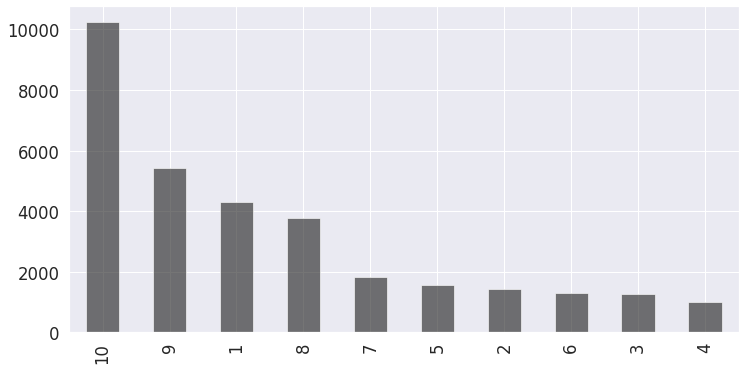

In [43]:
y = train['effectiveness_rating'].value_counts()
y.plot(kind='bar', color='k', alpha=0.6)

In [44]:
revs = train['review_by_patient']
from collections import Counter
top_n = 10
Counter(" ".join(revs).split()).most_common(top_n)

[('I', 131623),
 ('and', 83968),
 ('the', 72526),
 ('to', 63438),
 ('a', 56135),
 ('my', 49439),
 ('it', 39544),
 ('for', 39046),
 ('was', 34122),
 ('of', 33753)]

In [0]:
# Removing

--------------------------------------------------------------

In [0]:
!pip install bert-for-tf2 
!pip install sentencepiece

     |████████████████████████████████| 40kB 4.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.5-cp36-none-any.whl size=29948 sha256=a10666fc0bb0126f4f06e4dbe820719b8f3a910c2b7b3734752b300298e446d8
  Stored in directory: /root/.cache/pip/wheels/ed/11/48/86aff8a0442aa4728c921027a4100ac28878e9d977e76e2d52
  Created wheel for py-params: filename=py_params-0.9.2-cp36-none-any.whl size=6003 sha256=8a7235e93499f75432edb541d93c77a36291b136742acaba26a3cd9e84c97da3
  Stored in directory: /root/.cache/pip/wheels/da/d9/3a/d0b0aa570115d3a1a978deac820abc2afe34d7ca5e85dc236f
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=27c1a8480b43d27d07d493109ddf8584f5dc55a46caf458eadc50c2ff7200c28
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow


In [0]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from bert.tokenization.bert_tokenization import FullTokenizer

In [0]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

-------------------------------------------------------------------

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import re
import seaborn as sns

In [7]:
import torch

if torch.cuda.is_available():    
   device = torch.device("cuda")
   print('GPU:', torch.cuda.get_device_name(0))

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

GPU: Tesla T4


In [0]:
!pip install transformers

In [0]:
labels = train['effectiveness_rating']
reviews = train['review_by_patient']

In [12]:
# model building
from transformers import AlbertTokenizer 
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

In [13]:
print(' Original: ', reviews[0])
print('Tokenized: ', tokenizer.tokenize(reviews[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[0])))

 Original:  "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
Tokenized:  ['▁', '"', 'it', '▁has', '▁no', '▁side', '▁effect', ',', '▁i', '▁take', '▁it', '▁in', '▁combination', '▁of', '▁by', 'st', 'olic', '▁5', '▁mg', '▁and', '▁fish', '▁oil', '"']
Token IDs:  [13, 7, 242, 63, 90, 270, 1590, 15, 31, 247, 32, 19, 3733, 16, 34, 384, 18156, 331, 11791, 17, 1968, 1585, 7]


In [14]:
max_len = 0

# For every sentence...
for sent in reviews:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Max sentence length:  870


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [16]:
# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[0])
print('Token IDs:', input_ids[0])

Original:  "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
Token IDs: tensor([    2,    13,     7,   242,    63,    90,   270,  1590,    15,    31,
          247,    32,    19,  3733,    16,    34,   384, 18156,   331, 11791,
           17,  1968,  1585,     7,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [17]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 98-02 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.98 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

31,521 training samples
  644 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
#---------------------Training-----------------------

In [19]:
from transformers import AlbertForSequenceClassification, AdamW, AlbertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 10, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [20]:
# Interesting
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 27 different named parameters.

==== Embedding Layer ====

albert.embeddings.word_embeddings.weight                (30000, 128)
albert.embeddings.position_embeddings.weight              (512, 128)
albert.embeddings.token_type_embeddings.weight              (2, 128)
albert.embeddings.LayerNorm.weight                            (128,)
albert.embeddings.LayerNorm.bias                              (128,)

==== First Transformer ====

albert.encoder.embedding_hidden_mapping_in.weight         (768, 128)
albert.encoder.embedding_hidden_mapping_in.bias               (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias       (768,)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight   (768, 768)
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias       (768,)
albert.encoder.albert_layer_groups.0.albert_l

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Loop---------

In [25]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        #print('============\n', len(batch))

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2] - 1
        b_labels = b_labels.to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        #print(b_labels)
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #print('============\n', batch)
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2] - 1
        b_labels = b_labels.to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    986.    Elapsed: 0:00:15.
  Batch    80  of    986.    Elapsed: 0:00:31.
  Batch   120  of    986.    Elapsed: 0:00:46.
  Batch   160  of    986.    Elapsed: 0:01:02.
  Batch   200  of    986.    Elapsed: 0:01:18.
  Batch   240  of    986.    Elapsed: 0:01:34.
  Batch   280  of    986.    Elapsed: 0:01:50.
  Batch   320  of    986.    Elapsed: 0:02:06.
  Batch   360  of    986.    Elapsed: 0:02:22.
  Batch   400  of    986.    Elapsed: 0:02:38.
  Batch   440  of    986.    Elapsed: 0:02:54.
  Batch   480  of    986.    Elapsed: 0:03:10.
  Batch   520  of    986.    Elapsed: 0:03:26.
  Batch   560  of    986.    Elapsed: 0:03:42.
  Batch   600  of    986.    Elapsed: 0:03:59.
  Batch   640  of    986.    Elapsed: 0:04:15.
  Batch   680  of    986.    Elapsed: 0:04:31.
  Batch   720  of    986.    Elapsed: 0:04:47.
  Batch   760  of    986.    Elapsed: 0:05:03.
  Batch   800  of    986.    Elapsed: 0:05:19.
  Batch   840  o

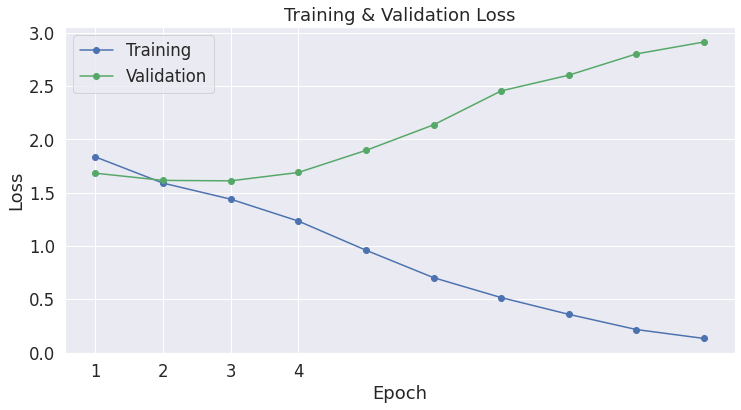

In [26]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [27]:
df_test.head()

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis
3,23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal
4,97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia


In [28]:
test = df_test.drop(drop_cols, axis=1)
test.head()

,patient_id,review_by_patient
0,163740,"""I&#039;ve tried a few antidepressants over th..."
1,39293,"""Contrave combines drugs that were used for al..."
2,208087,"""4 days in on first 2 weeks. Using on arms an..."
3,23295,"""Ive been on Methadone for over ten years and ..."
4,97013,"""Ditto on rebound sleepless when discontinued...."


In [0]:
test_rev = test['review_by_patient']

In [30]:
print('Number of test sentences: {:,}\n'.format(len(test_rev)))

# Create sentence and label lists
sentences = test_rev
#labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)#, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 10,760



In [31]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  
  # Unpack the inputs from our dataloader
  #b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask= batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 10,760 test sentences...
    DONE.


In [0]:
pred = np.array(predictions)
pred.shape

(337,)

In [32]:
len(predictions)

337

In [33]:
labels_pre = []
for i in range(len(predictions)):
  for k in predictions[i]:
    maxx = np.argmax(k)
    labels_pre.append(maxx)

len(labels_pre)

10760

In [34]:
submit = pd.DataFrame(columns=['patient_id', 'effectiveness_rating'],)
submit

,patient_id,effectiveness_rating


In [35]:
submit['patient_id'] = test['patient_id']
submit.head()

,patient_id,effectiveness_rating
0,163740,NaN
1,39293,NaN
2,208087,NaN
3,23295,NaN
4,97013,NaN


In [0]:
labels_pre = np.array(labels_pre)
labels_pre = labels_pre + 1

In [37]:
submit['effectiveness_rating'] = labels_pre
submit.head()

,patient_id,effectiveness_rating
0,163740,9
1,39293,8
2,208087,10
3,23295,5
4,97013,5


In [0]:
submit.to_csv('dedoyaar.csv', index=False)

In [0]:
submit['effectiveness_rating'].value_counts() #  10 9 1 8 7 5 2 6 3 4

10    4437
1     1860
8     1372
9     1304
5      742
7      454
2      251
3      204
6       89
4       47
Name: effectiveness_rating, dtype: int64

In [0]:
submit.effectiveness_rating[labels_pre == 1] = 9
submit.effectiveness_rating[labels_pre == 8] = 1
submit.effectiveness_rating[labels_pre == 9] = 8
submit.effectiveness_rating[labels_pre == 5] = 7
submit.effectiveness_rating[labels_pre == 7] = 5
submit.effectiveness_rating[labels_pre == 2] = 2
submit.effectiveness_rating[labels_pre == 3] = 6
submit.effectiveness_rating[labels_pre == 6] = 3

#submit[labels_pre == 10] = 10
#submit[labels_pre == 4] = 4

In [0]:
submit.to_csv('nabhey_do.csv', index=False)

In [0]:
submit[submit['patient_id'] == 16384]

,patient_id,effectiveness_rating
